Creating an API connection to the FDA and pulling in the data to MongoDB

In [ ]:
import requests
import pandas as pd
from pymongo import MongoClient
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Define the API endpoint and parameters
url = "https://api.fda.gov/food/enforcement.json?search=report_date:[20200101+TO+20241201]&limit=1000"

# Send a GET request to the API
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    recalls = data.get('results', [])
    recall_df = pd.DataFrame(recalls)

    # Convert DataFrame to dictionary format for MongoDB
    recall_records = recall_df.to_dict("records")

    # Establish a connection to MongoDB
    client = MongoClient('mongodb://localhost:27017/')  # Replace with your MongoDB connection string

    # Access a database and collection
    db = client["fda_data"]  # Replace "fda_data" with your desired database name
    collection = db["food_recalls"]  # Replace "food_recalls" with your desired collection name

    # Insert modified data into MongoDB
    collection.insert_many(recall_records)

else:
    print(f"Failed to retrieve data: {response.status_code}")


In [3]:
# Checking number of recoreds pulled in from the FDA
num_records = len(recall_records)
num_records 

1000

Cleaning & Formating Data in MongoDB

In [4]:
####### CLEANING, FILTERING COLUMNS & HEADERS #######

# Finding and droping all NaNs from the "termination_date" column 
collection.find({"termination_date": {"$in": [None, "", float("nan")]}})
collection.delete_many({"termination_date": {"$in": [None, float("nan")]}})

# Filter by 'United States' only and remove all other Countries
collection.delete_many({"country": {"$ne": "United States"}})

# Removing the columns not needed
collection.update_many({}, {"$unset": {"openfda": "",
                                       "event_id": "", 
                                       "product_type": "",
                                       "address_2": "",                                           
                                       "voluntary_mandated": "",
                                       "initial_firm_notification": "",
                                       "distribution_pattern": "",
                                       "recall_number": "",
                                       "product_description": "",
                                       "product_quantity": "",
                                       "reason_for_recall": "",
                                       "report_date": "",
                                       "code_info": "",
                                       "more_code_info": ""
                                       }}          
)

# Renaming the columns
collection.update_many({}, {"$rename": {"status": "Status",
                                        "city": "City",
                                        "state": "State",
                                        "country": "Country",
                                        "classification": "Classification",
                                        "recalling_firm": "Recall Firm",
                                        "address_1": "Address",
                                        "postal_code": "Postal Code",
                                        "recall_initiation_date": "Recall Initiation Date",
                                        "center_classification_date": "Center Classification Date",
                                        "termination_date": "Termination Date"
                                        }}
)

####### FORMATING DATE COLUMNS #######

for date_field in ["Center Classification Date", "Recall Initiation Date", "Termination Date"]:
    documents = collection.find({date_field: {"$exists": True}})
    for doc in documents:
        date_str = doc.get(date_field)
        
        # Check if the date_str is a valid string and is 8 digits long
        if isinstance(date_str, str) and len(date_str) == 8 and date_str.isdigit():
            try:
                formatted_date = datetime.strptime(date_str, "%Y%m%d")
                collection.update_one(
                    {"_id": doc["_id"]},
                    {"$set": {date_field: formatted_date}}
                )
            except ValueError as e:
                print(f"Error parsing date for document ID {doc['_id']}: {e}")
        else:
            # Log or handle cases where date_str is not a valid string or is not 8 digits long
            print(f"Skipping invalid date for document ID {doc['_id']}: {date_str}")


####### CALCULATING DAYS FOR CLASSIFICATION #######

# Adding new column for days it to to classify and calculating its value
new_column = "Days To Classify"

for document in collection.find():
    start_date = document.get("Recall Initiation Date")
    end_date = document.get("Center Classification Date")
    
    if start_date and end_date:
        new_column_value = (end_date - start_date).days
        collection.update_one(
            {"_id": document["_id"]},
            {"$set": {"Days To Classify": new_column_value}}
        )

collection.find_one()

{'_id': ObjectId('67579303b573cb028daaa71c'),
 'Address': '2610 Homestead Pl',
 'Center Classification Date': datetime.datetime(2020, 4, 13, 0, 0),
 'City': 'Rancho Dominguez',
 'Classification': 'Class III',
 'Country': 'United States',
 'Postal Code': '90220-5610',
 'Recall Firm': 'Organic By Nature, Inc.',
 'Recall Initiation Date': datetime.datetime(2020, 2, 24, 0, 0),
 'State': 'CA',
 'Status': 'Terminated',
 'Termination Date': datetime.datetime(2021, 2, 2, 0, 0),
 'Days To Classify': 49}

In [5]:
# Query data back from MongoDB to a Data Frame
recalls_from_db = list(collection.find())

# Convert back to DataFrame if needed
db_df = pd.DataFrame(recalls_from_db)

# Checking number of recoreds remaining after clean up
clean_records = len(db_df)
clean_records

848

In [6]:
db_df.to_csv('clean_records.csv', index=False)

In [7]:
# Load the dataset
file_path = 'clean_records.csv'  
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df.head()

,_id,Address,Center Classification Date,City,Classification,Country,Postal Code,Recall Firm,Recall Initiation Date,State,Status,Termination Date,Days To Classify
0,67579303b573cb028daaa71c,2610 Homestead Pl,2020-04-13,Rancho Dominguez,Class III,United States,90220-5610,"Organic By Nature, Inc.",2020-02-24,CA,Terminated,2021-02-02,49
1,67579303b573cb028daaa71d,47 Bridgewater St # 57,2020-04-24,Brooklyn,Class III,United States,11222-3820,Rong Shing Trading NY Inc,2020-04-01,NY,Terminated,2021-03-18,23
2,67579303b573cb028daaa71e,2959 Salinas Hwy,2022-02-22,Monterey,Class I,United States,93940-6400,Dole Fresh Vegetables Inc,2022-01-06,CA,Terminated,2022-03-22,47
3,67579303b573cb028daaa71f,262 E Main St,2022-07-19,Lovell,Class II,United States,82431-2102,"Queen Bee Gardens, LLC",2022-04-28,WY,Terminated,2023-01-17,82
4,67579303b573cb028daaa723,1700 E Stroop Rd,2023-08-02,Dayton,Class II,United States,45429-5040,Cassanos Inc,2023-07-18,OH,Terminated,2023-09-27,15


In [8]:
# Data Preparation

# Convert date columns to datetime
df['Center Classification Date'] = pd.to_datetime(df['Center Classification Date'], errors='coerce')
df['Termination Date'] = pd.to_datetime(df['Termination Date'], errors='coerce')

# Compute the target variable: how many days the recall lasted
df['Days_Outstanding'] = (df['Termination Date'] - df['Center Classification Date']).dt.days

# Select features and target
features = ['Classification', 'Country', 'State', 'Days To Classify']
X = df[features]
y = df['Days_Outstanding']


X.head()

,Classification,Country,State,Days To Classify
0,Class III,United States,CA,49
1,Class III,United States,NY,23
2,Class I,United States,CA,47
3,Class II,United States,WY,82
4,Class II,United States,OH,15


In [11]:
# Encoding Categorical Variables

categorical_cols = ['Classification', 'Country', 'State']
numeric_cols = ['Days To Classify']

# Create the OneHotEncoder, ensuring output is dense (non-sparse array)
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit the encoder on categorical columns and transform
X_cat = encoder.fit_transform(X[categorical_cols])

# Extract numeric features as a NumPy array
X_num = X[numeric_cols].values

# Combine encoded categorical features and numeric features
X_prepared = np.hstack([X_cat, X_num])

X_prepared.shape

(848, 50)

In [12]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((678, 50), (170, 50))

In [13]:
# Model Training

# Initialize the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

In [14]:
# Model Evaluation

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculate MSE and then RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Calculate R2 Score
r2 = r2_score(y_test, y_pred)

# Print the metrics
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R2 Score:", r2)

Mean Absolute Error (MAE): 57.399407179421885
Root Mean Squared Error (RMSE): 113.23933178297544
R2 Score: 0.66181594985805


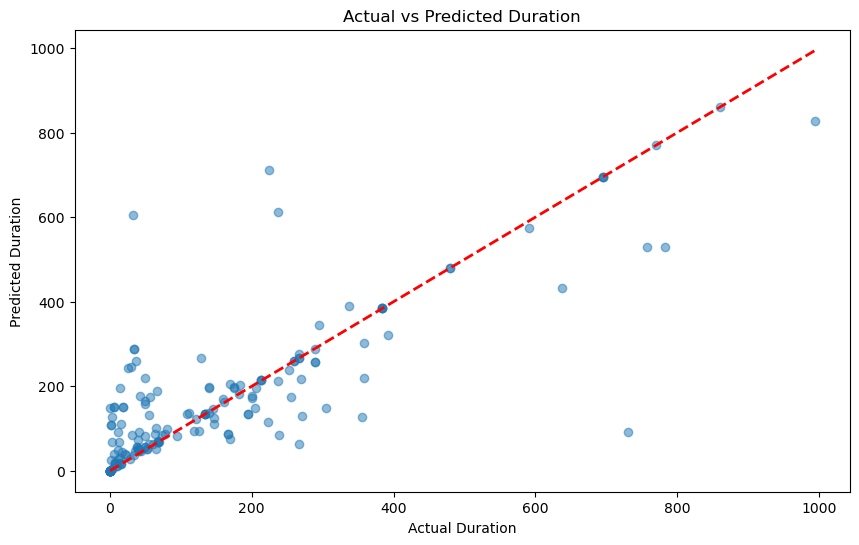

In [15]:
# Plot actual vs predicted durations
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)  # 
plt.xlabel('Actual Duration')
plt.ylabel('Predicted Duration')
plt.title('Actual vs Predicted Duration')
plt.show()